Two-Class Classification: classifies movie reviews as positive or negative.

Uses: IMDB dataset, 50,000 movie reviews. This dataset comes packaged with TensorFlow.

The dataset has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

Implemented following this google tutorial: https://www.tensorflow.org/tutorials/keras/basic_text_classification

In [1]:
from __future__ import absolute_import, division, print_function

#uses keras - a high-level api to build and train models in tensorflow
import tensorflow as tf
from tensorflow import keras

#uses numpy - adds support for large, multi-dimensional arrays and matrices,
#along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np

print(tf.__version__)

1.12.0


In [2]:
#downloads the IMDB dataset to your machine or uses a cached copy if you've already downloaded it
imdb = keras.datasets.imdb

#keeps the top 10,000 most frequently occurring words in the training data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [3]:
#each example is an array of integers representing the words of the movie review
#each label is an integer value of either 0 or 1, where 0 is a negative review, 
#and 1 is a positive review
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
#the text of reviews have been converted to integers, 
#where each integer represents a specific word in a dictionary
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
#number of words in the first and second reviews
#unequal - inputs to a neural network must be the same length, so this must be resolved
len(train_data[0]), len(train_data[1])

(218, 189)

Convert the integers back to words.

Additionally, the movie reviews must be the same length, so the pad_sequences function is used to standardize the lengths.

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

The neural network is created by stacking layers. The input data consists of an array of word-indices. The labels to predict are either 0 or 1.

In [9]:
#binary classification problem, model outputs a probability 
#(a single-unit layer with a sigmoid activation)

# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
#takes the integer-encoded vocabulary and looks up the embedding vector for each word-index
model.add(keras.layers.Embedding(vocab_size, 16))
#returns a fixed-length output vector for each example by averaging over the sequence dimension
model.add(keras.layers.GlobalAveragePooling1D())
#fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
#Using the sigmoid activation function, output is a float between 0 and 1, 
#representing a probability, or confidence level.
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [10]:
#binary_crossentropy loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
#setting apart 10,000 examples from the original training data - validation set
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [12]:
#train the model for 40 epochs (iterations over all samples in the x_train and y_train) 
#in mini-batches of 512 samples

#while training, monitor the model's loss and accuracy on the 10,000 samples from the 
#validation set
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 59us/step - loss: 0.6924 - acc: 0.5494 - val_loss: 0.6913 - val_acc: 0.6204
Epoch 2/40
15000/15000 [==============================] - 1s 33us/step - loss: 0.6885 - acc: 0.7187 - val_loss: 0.6850 - val_acc: 0.7042
Epoch 3/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.6785 - acc: 0.7514 - val_loss: 0.6715 - val_acc: 0.7468
Epoch 4/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.6586 - acc: 0.7503 - val_loss: 0.6483 - val_acc: 0.7710
Epoch 5/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.6275 - acc: 0.7877 - val_loss: 0.6136 - val_acc: 0.7777
Epoch 6/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.5856 - acc: 0.8038 - val_loss: 0.5721 - val_acc: 0.7884
Epoch 7/40
15000/15000 [==============================] - 0s 33us/step - loss: 0.5377 - acc: 0.8251 - val_loss: 0.5277 - val_acc

In [13]:
#Evaluate model via - loss (a number which represents our error, lower values are better), 
#and accuracy.
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 0s 11us/step
[0.3283764894294739, 0.87268]


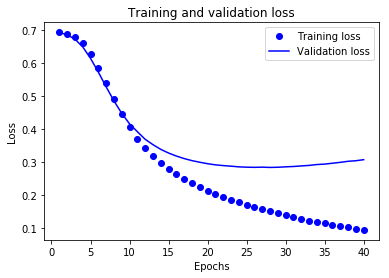

In [15]:
#a dictionary with everything that happened during training
history_dict = history.history
history_dict.keys()

#create a graph of accuracy and loss over time
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

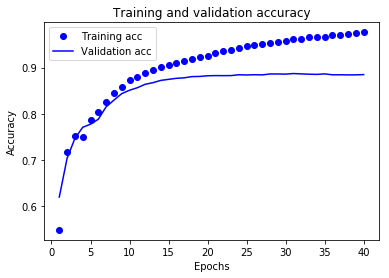

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The training loss decreases with each epoch and the training accuracy increases with each epoch.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before.

After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this case, overfitting can be prevented by stopping the training after twenty or so epochs.